<a href="https://colab.research.google.com/github/mmilannaik/BigOCheatSheet/blob/master/Miq_Times%20Internet_Marketing_A_B_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
faviovaz_marketing_ab_testing_path = kagglehub.dataset_download('faviovaz/marketing-ab-testing')

print('Data source import complete.')


100%|██████████| 5.23M/5.23M [00:00<00:00, 33.6MB/s]

Extracting files...


Data source import complete.


**Marketing A/B testing dataset**

Marketing companies want to run successful campaigns, but the market is complex and several options can work. So normally they run A/B tests, that is a randomized experimentation process wherein two or more versions of a variable (web page, page element, banner, etc.) are shown to different segments of people at the same time to determine which version leaves the maximum impact and drive business metrics.

The companies are interested in answering two questions:

* Would the campaign be successful?

* If the campaign was successful, how much of that success could be attributed to the ads?

With the second question in mind, we normally do an A/B test. The majority of the people will be exposed to ads (the experimental group). And a small portion of people (the control group) would instead see a Public Service Announcement (PSA) (or nothing) in the exact size and place the ad would normally be.

The idea of the dataset is to analyze the groups, find if the ads were successful, how much the company can make from the ads, and if the difference between the groups is statistically significant.

Data dictionary:

* Index: Row index
* user id: User ID (unique)
* test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
* converted: If a person bought the product then True, else is False
* total ads: Amount of ads seen by person
* most ads day: Day that the person saw the biggest amount of ads
* most ads hour: Hour of day that the person saw the biggest amount of ads

https://www.kaggle.com/code/mohammadnaserian/a-b-testing-deep-analyzing/input


# EDA

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
df = pd.read_csv('/content/marketing_AB.csv')
df

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14
...,...,...,...,...,...,...,...
588096,588096,1278437,ad,False,1,Tuesday,23
588097,588097,1327975,ad,False,1,Tuesday,23
588098,588098,1038442,ad,False,3,Tuesday,23
588099,588099,1496395,ad,False,1,Tuesday,23


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


In [26]:
duplicates = df[df.duplicated('user id', keep=False)]
duplicates

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour


In [27]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
numeric_cols = df.select_dtypes(include=['number'])
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define outliers as points outside 1.5 * IQR range
outliers = ((numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR)))

# Print outliers for each column
outliers_count = outliers.sum()
print("Number of outliers in each column:")
print(outliers_count)

# Optionally, filter the outliers from the DataFrame
df_outliers = numeric_cols[outliers.any(axis=1)]
print("Data points considered as outliers:")
print(df_outliers)

Number of outliers in each column:
Unnamed: 0           0
user id              0
total ads        52057
most ads hour     5536
dtype: int64
Data points considered as outliers:
        Unnamed: 0  user id  total ads  most ads hour
0                0  1069124        130             20
1                1  1119715         93             22
3                3  1435133        355             10
4                4  1015700        276             14
5                5  1137664        734             10
...            ...      ...        ...            ...
584639      584639  1004190          1              0
584640      584640  1028589          1              0
584641      584641  1536866          1              0
584642      584642  1089798          1              0
584643      584643  1096523          1              0

[57135 rows x 4 columns]


In [28]:
df.isna().sum()

,0
Unnamed: 0,0
user id,0
test group,0
converted,0
total ads,0
most ads day,0
most ads hour,0


In [29]:
cont_var = ['total ads','most ads hour']
cat_var = ['test group','converted','most ads day']

**Frequency Table and Mode for Categorical Variables**

Frequency tables organize and display the **counts** and **percentages** of **different categories** in a dataset, offering a snapshot of categorical data distribution. Meanwhile, the mode pinpoints the **most frequently** occurring category, serving as a quick reference for the dominant aspect of the data. Together, they provide a concise yet insightful analysis, aiding in identifying patterns and making informed interpretations of categorical variables.

In [30]:
def frequency_table(variable):

    # Get unique elements and their counts
    unique_elements, counts = np.unique(variable.dropna(), return_counts=True)

    # Calculate percentages
    percentages = (counts / len(variable)) * 100

    # Create a dictionary to store the value counts and percentages
    value_counts_and_percentages = zip(unique_elements, counts, percentages)

    # Print the value counts and percentages
    for i, j, k in value_counts_and_percentages:
        print(f"{i}: Count: {j}, Percentage: {k:.2f}%")
    return


# Calculate frequency table and mode for each categorical variable
for var in cat_var:
    print (f"frequency table for {var}")
    frequency_table(df[var])
    print("Mode =", df[var].mode()[0])
    print ("#"*50)

frequency table for test group
ad: Count: 564577, Percentage: 96.00%
psa: Count: 23524, Percentage: 4.00%
Mode = ad
##################################################
frequency table for converted
False: Count: 573258, Percentage: 97.48%
True: Count: 14843, Percentage: 2.52%
Mode = False
##################################################
frequency table for most ads day
Friday: Count: 92608, Percentage: 15.75%
Monday: Count: 87073, Percentage: 14.81%
Saturday: Count: 81660, Percentage: 13.89%
Sunday: Count: 85391, Percentage: 14.52%
Thursday: Count: 82982, Percentage: 14.11%
Tuesday: Count: 77479, Percentage: 13.17%
Wednesday: Count: 80908, Percentage: 13.76%
Mode = Friday
##################################################


**Advanced Statistics for Continuous Variables**

**Basic statistics** like **mean** and **standard deviation** offer a fundamental grasp of **continuous** variables. Going beyond, **skewness** and **kurtosis** provide advanced insights. Skewness indicates the distribution's asymmetry, with positive values suggesting a longer right tail and negative values indicating a longer left tail. Kurtosis measures the distribution's peakedness, with higher values indicating a more peaked shape. These **advanced statistics** add depth to understanding the nuances of continuous variables, offering a comprehensive view of **distributional characteristics** beyond basic measures.

In [12]:
concatenated_series = pd.concat([
    df[cont_var].describe().T,
    df[cont_var].skew().rename('skewness'),
    df[cont_var].kurtosis().rename('kurtosis')
], axis=1)


# Adding lower and upper confidence intervals
confidence_level = 0.95  # 95% confidence interval

for var in cont_var:
    values = df[var].dropna()
    mean = values.mean()
    std_error = stats.sem(values)
    if std_error != 0:
        lower, upper = stats.t.interval(confidence_level, len(values) - 1, loc=mean, scale=std_error)
    else:
        lower, upper = mean, mean

    # Adding lower and upper confidence intervals to the concatenated series
    concatenated_series.loc[var, 'lower_ci'] = lower
    concatenated_series.loc[var, 'upper_ci'] = upper
concatenated_series

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis,lower_ci,upper_ci
total ads,588101.0,24.820876,43.715181,1.0,4.0,13.0,27.0,2065.0,7.433113,109.917983,24.709150,24.932602
most ads hour,588101.0,14.469061,4.834634,0.0,11.0,14.0,18.0,23.0,-0.336972,0.103237,14.456704,14.481417


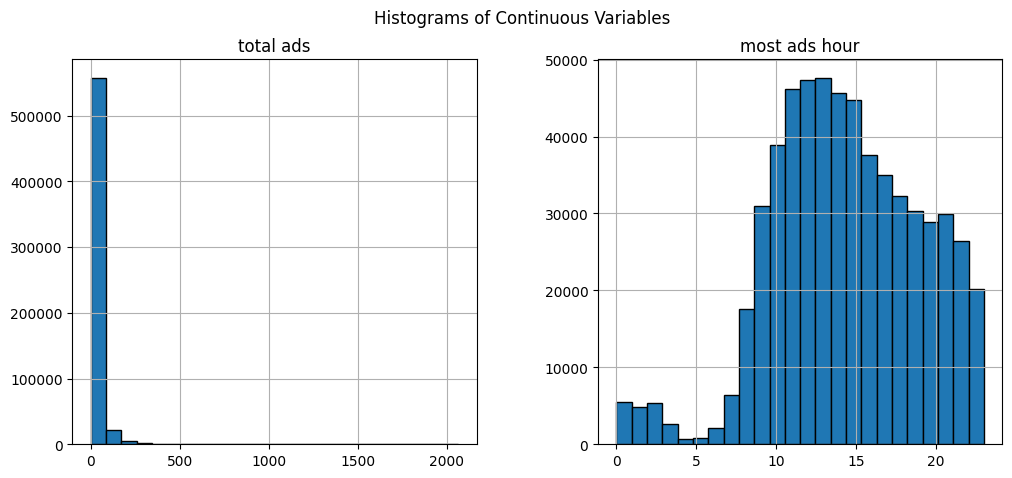

In [13]:
import matplotlib.pyplot as plt


cont_var = ['total ads', 'most ads hour']

# Plot histograms for each continuous variable
df[cont_var].hist(bins=24, figsize=(12, 5), edgecolor='black')

plt.suptitle('Histograms of Continuous Variables')
plt.show()


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


# The Chi-Square Test for independece

## Converted and most ads day

In [15]:
import numpy as np
import pandas as pd
from scipy.stats import norm

def OR_CIs(contingency_table):

    # Calculate odds ratio
    odds_ratio = (contingency_table.iloc[0, 0] / contingency_table.iloc[0, 1]) / (contingency_table.iloc[1, 0] / contingency_table.iloc[1, 1])

    # Calculate standard error of log(odds ratio)
    log_odds_std_error = np.sqrt(contingency_table.applymap(lambda x: 1/x).sum().sum())

    # Set confidence level
    confidence_level = 0.95

    # Calculate z-score for the confidence interval
    z_score = norm.ppf(1-(1 - confidence_level) / 2)

    # Calculate confidence intervals
    ci_low = np.exp(np.log(odds_ratio) - z_score * log_odds_std_error)
    ci_high = np.exp(np.log(odds_ratio) + z_score * log_odds_std_error)

    # Print the results
    print(f"Odds Ratio: {odds_ratio:.2f}")
    print(f"95% Confidence Interval: {ci_low:.2f}, {ci_high:.2f}")

    return

In [16]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df['converted'], df['most ads day'])

print("Contingency Table with Frequencies:")
display(contingency_table)
print("#"*60)

# Calculate row percentages
row_percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("\nRow Percentages:")
display(row_percentages)
print("#"*60)

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-squared value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("#"*60)

# Calculate the percentage of cells with expected counts less than 5
percentage_low_expected = (expected < 5).sum().sum() / (expected.shape[0] * expected.shape[1]) * 100

print(f"Percentage of cells with expected counts less than 5: {percentage_low_expected:.2f}%")
print("#"*60)

# Calculate residuals (observed minus expected values)
residuals = contingency_table - expected

print("\nResiduals (Observed - Expected):")
display(residuals)
print("#"*60)

# Calculate odds ratio
OR_CIs(contingency_table)

Contingency Table with Frequencies:


most ads day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
converted,,,,,,,
False,90551,84216,79941,83301,81192,75167,78890
True,2057,2857,1719,2090,1790,2312,2018


############################################################

Row Percentages:


most ads day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
converted,,,,,,,
False,15.795855,14.690768,13.945030,14.531154,14.163256,13.112246,13.761692
True,13.858384,19.248130,11.581217,14.080711,12.059557,15.576366,13.595634


############################################################

Chi-squared value: 410.0478857936585
P-value: 1.932184379244731e-85
Degrees of freedom: 6
############################################################
Percentage of cells with expected counts less than 5: 0.00%
############################################################

Residuals (Observed - Expected):


most ads day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
converted,,,,,,,
False,280.320535,-659.376566,342.005474,65.171668,304.371249,-356.518209,24.025849
True,-280.320535,659.376566,-342.005474,-65.171668,-304.371249,356.518209,-24.025849


############################################################
Odds Ratio: 1.49
95% Confidence Interval: 1.33, 1.68


### Interpretation:

#### 1. **Contingency Table:**
   - This table shows the count of conversions and non-conversions (True/False) based on the most frequent day users saw ads.
   - For example, on Friday, 90,551 users did not convert, and 2,057 users converted.

#### 2. **Row Percentages:**
   - These percentages show how conversions and non-conversions are distributed across different days.
   - Among the users who did not convert, 15.80% saw ads mostly on Friday, while 13.11% saw ads mostly on Tuesday.
   - Among users who converted, the largest percentage (19.25%) saw ads mostly on Monday, while the lowest percentage (11.58%) saw ads on Saturday.

#### 3. **Chi-Squared Test:**
   - **Chi-squared value:** 410.05
   - **P-value:** \(1.93 \times 10^{-85}\)
   - **Degrees of freedom:** 6
   - The very low p-value indicates a statistically significant association between the day users saw the most ads and their conversion status. This suggests that the day on which users saw the most ads had a meaningful impact on whether they converted or not.

#### 4. **Residuals:**
   - Positive residuals mean that the actual count is higher than the expected count, and negative residuals mean the actual count is lower than expected.
   - For example:
     - **Monday (True):** The positive residual (659.38) means more people converted on Monday than expected.
     - **Saturday (True):** The negative residual (-342.01) indicates fewer people converted on Saturday than expected.

#### 5. **Odds Ratio:**
   - **Odds ratio:** 1.49 (Confidence Interval: 1.33 to 1.68)
   - This means that users who saw ads most frequently on one day are 1.49 times more likely to convert compared to other users. The confidence interval indicates that this effect is likely to be true and not due to random chance.

#### 6. **Conclusion:**
   - There is a strong association between the day users see the most ads and their conversion likelihood.
   - Users seeing ads most frequently on **Monday** tend to convert more, while **Saturday** seems to have the least conversions.
   - The overall odds of converting are increased for users based on the day they view ads the most frequently.

**visulize Converted and most ads day**

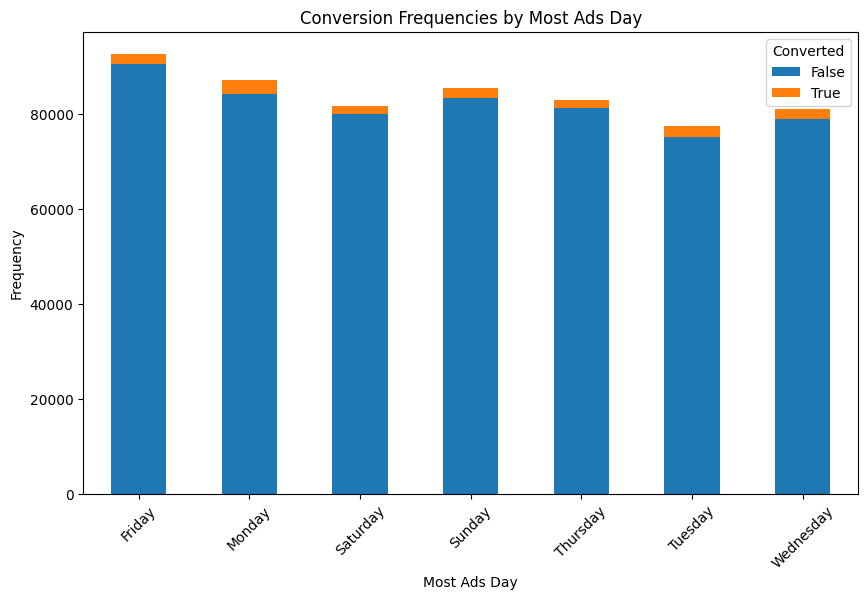

In [17]:
import matplotlib.pyplot as plt


# Data
categories = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
false_values = [90551, 84216, 79941, 83301, 81192, 75167, 78890]
true_values = [2057, 2857, 1719, 2090, 1790, 2312, 2018]

# Create a DataFrame
df = pd.DataFrame({
    'False': false_values,
    'True': true_values
}, index=categories)

# Plot
df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Conversion Frequencies by Most Ads Day')
plt.xlabel('Most Ads Day')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Converted')
plt.show()


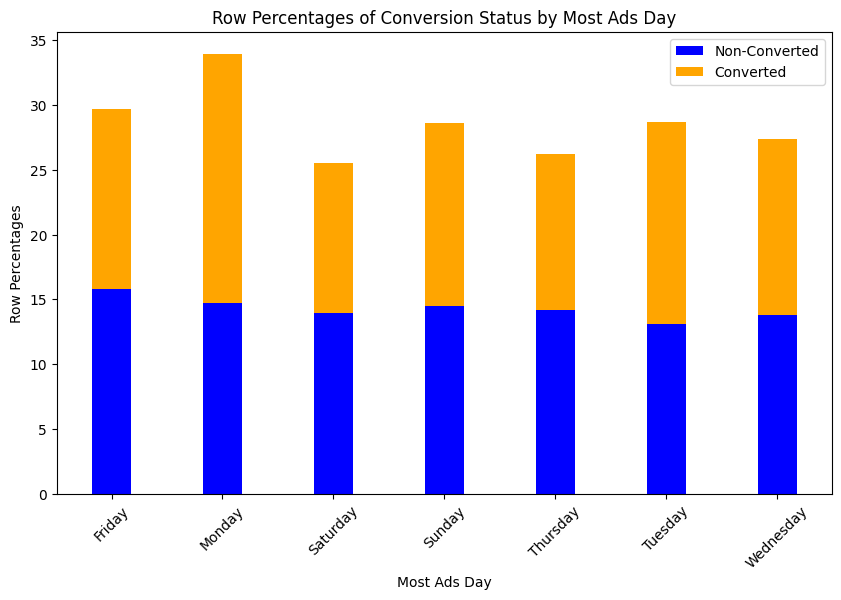

In [18]:
false_percentages = [15.795855, 14.690768, 13.945030, 14.531154, 14.163256, 13.112246, 13.761692]
true_percentages = [13.858384, 19.248130, 11.581217, 14.080711, 12.059557, 15.576366, 13.595634]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35  # Width of the bars
ax.bar(categories, false_percentages, width, label='Non-Converted', color='blue')
ax.bar(categories, true_percentages, width, bottom=false_percentages, label='Converted', color='orange')

ax.set_xlabel('Most Ads Day')
ax.set_ylabel('Row Percentages')
ax.set_title('Row Percentages of Conversion Status by Most Ads Day')
ax.legend()

plt.xticks(rotation=45)
plt.show()


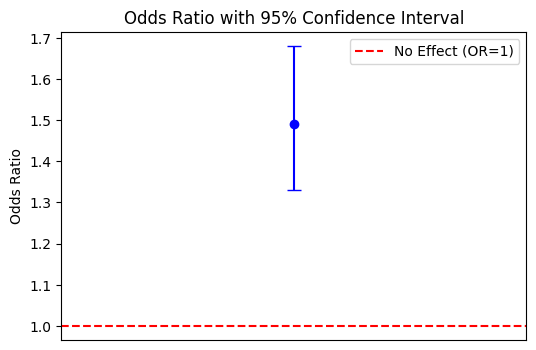

In [21]:
odds_ratio = 1.49
conf_int = [1.33, 1.68]

plt.figure(figsize=(6, 4))
plt.errorbar(1, odds_ratio, yerr=[[odds_ratio - conf_int[0]], [conf_int[1] - odds_ratio]], fmt='o', capsize=5, color='blue')
plt.axhline(1, linestyle='--', color='red', label='No Effect (OR=1)')
plt.title('Odds Ratio with 95% Confidence Interval')
plt.ylabel('Odds Ratio')
plt.xlim(0.5, 1.5)
plt.xticks([])
plt.legend()
plt.show()


## Converted and Most ads hour

**categorize hours into time slots**

In [31]:
df.columns

Index(['Unnamed: 0', 'user id', 'test group', 'converted', 'total ads',
       'most ads day', 'most ads hour'],
      dtype='object')

In [32]:
# Define a function to categorize hours into time slots
def categorize_hour(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# Apply the function to create a new column in the DataFrame
df['time_slot'] = df['most ads hour'].apply(categorize_hour)

# Display the updated DataFrame
print(df)

        Unnamed: 0  user id test group  converted  total ads most ads day  \
0                0  1069124         ad      False        130       Monday   
1                1  1119715         ad      False         93      Tuesday   
2                2  1144181         ad      False         21      Tuesday   
3                3  1435133         ad      False        355      Tuesday   
4                4  1015700         ad      False        276       Friday   
...            ...      ...        ...        ...        ...          ...   
588096      588096  1278437         ad      False          1      Tuesday   
588097      588097  1327975         ad      False          1      Tuesday   
588098      588098  1038442         ad      False          3      Tuesday   
588099      588099  1496395         ad      False          1      Tuesday   
588100      588100  1237779         ad      False          1      Tuesday   

        most ads hour  time_slot  
0                  20    Evening  
1    

In [33]:


# Create a contingency table
contingency_table_T = pd.crosstab(df['converted'], df['time_slot'])

print("Contingency Table with Frequencies:")
display(contingency_table_T)
print("#"*60)

# Calculate row percentages
row_percentages_T = contingency_table_T.div(contingency_table_T.sum(axis=1), axis=0) * 100

print("\nRow Percentages:")
display(row_percentages_T)
print("#"*60)

# Perform chi-square test
chi2, p, dof, expected_T = chi2_contingency(contingency_table_T)

print(f"\nChi-squared value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("#"*60)

# Calculate the percentage of cells with expected counts less than 5
percentage_low_expected_T = (expected < 5).sum().sum() / (expected.shape[0] * expected.shape[1]) * 100

print(f"Percentage of cells with expected counts less than 5: {percentage_low_expected_T:.2f}%")
print("#"*60)

# Calculate residuals (observed minus expected values)
residuals_T = contingency_table_T - expected_T

print("\nResiduals (Observed - Expected):")
display(residuals_T)
print("#"*60)

# Calculate odds ratio
OR_CIs(contingency_table_T)

Contingency Table with Frequencies:


time_slot,Afternoon,Evening,Morning,Night
converted,,,,
False,216786,123041,140041,93390
True,6065,3545,2977,2256


############################################################

Row Percentages:


time_slot,Afternoon,Evening,Morning,Night
converted,,,,
False,37.816481,21.463460,24.428966,16.291094
True,40.861012,23.883312,20.056592,15.199084


############################################################

Chi-squared value: 199.10145345082745
P-value: 6.596461961915453e-43
Degrees of freedom: 3
############################################################
Percentage of cells with expected counts less than 5: 0.00%
############################################################

Residuals (Observed - Expected):


time_slot,Afternoon,Evening,Morning,Night
converted,,,,
False,-440.494357,-350.113411,632.61157,157.996198
True,440.494357,350.113411,-632.61157,-157.996198


############################################################
Odds Ratio: 1.03
95% Confidence Interval: 0.96, 1.10



#### 1. **Contingency Table:**
   - This table shows the count of conversions and non-conversions (True/False) based on the time slot users saw ads.
   - For example, in the **Afternoon**, 216,786 users did not convert, and 6,065 users converted.

#### 2. **Row Percentages:**
   - These percentages show how conversions and non-conversions are distributed across different time slots.
   - Among the users who did not convert, 37.82% saw ads mostly in the **Afternoon**, while 16.29% saw ads mostly at **Night**.
   - Among users who converted, 40.86% saw ads in the **Afternoon**, while 15.20% saw ads at **Night**.
   - This indicates that a slightly higher percentage of conversions occurred in the **Afternoon** than in other time slots.

#### 3. **Chi-Squared Test:**
   - **Chi-squared value:** 199.10
   - **P-value:** \(6.60 \times 10^{-43}\)
   - **Degrees of freedom:** 3
   - The very low p-value suggests a statistically significant association between the time slot users saw ads and their conversion status. This indicates that the time slot of the ad exposure has a meaningful impact on whether users convert.

#### 4. **Residuals:**
   - Positive residuals mean the actual count is higher than expected, and negative residuals mean the actual count is lower than expected.
   - For example:
     - **Morning (False):** The positive residual (632.61) means that more users who saw ads in the morning did not convert than expected.
     - **Afternoon (True):** The positive residual (440.49) indicates that more users converted in the afternoon than expected.

#### 5. **Odds Ratio:**
   - **Odds ratio:** 1.03 (Confidence Interval: 0.96 to 1.10)
   - The odds ratio close to 1 suggests that the time slot when users saw ads does not substantially increase or decrease their likelihood of conversion. In other words, the impact of the time slot on conversion odds is minimal.

#### 6. **Conclusion:**
   - There is a statistically significant association between the **time slot** users saw ads and their conversion likelihood, but the odds ratio indicates that this effect is small.
   - Users who saw ads in the **Afternoon** are slightly more likely to convert, but the difference across time slots is not dramatic.
   - The **Afternoon** appears to be the most effective time slot for conversions, while the **Morning** shows more non-conversions than expected. However, the overall effect is not very strong.

**visulize Converted and most ads hour**

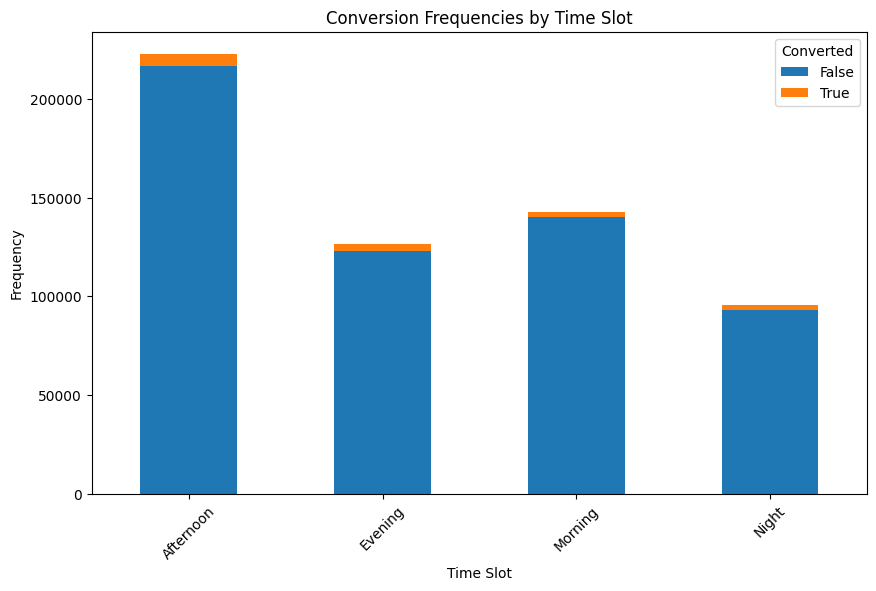

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
categories = ['Afternoon', 'Evening', 'Morning', 'Night']
false_values = [216786, 123041, 140041, 93390]
true_values = [6065, 3545, 2977, 2256]

# Create a DataFrame
df = pd.DataFrame({
    'False': false_values,
    'True': true_values
}, index=categories)

# Plot
df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Conversion Frequencies by Time Slot')
plt.xlabel('Time Slot')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Converted')
plt.show()


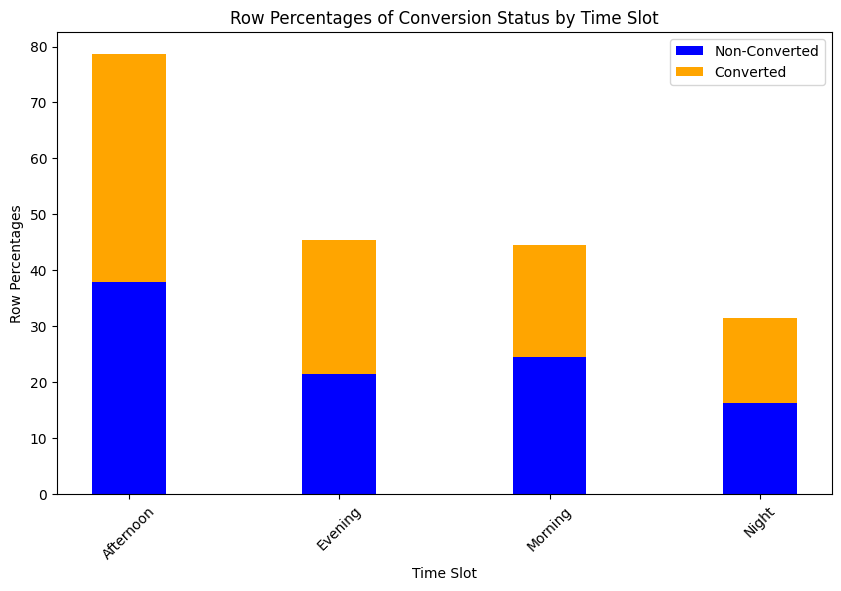

In [35]:
false_percentages = [37.82, 21.46, 24.43, 16.29]
true_percentages = [40.86, 23.88, 20.06, 15.20]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35  # Width of the bars
ax.bar(categories, false_percentages, width, label='Non-Converted', color='blue')
ax.bar(categories, true_percentages, width, bottom=false_percentages, label='Converted', color='orange')

ax.set_xlabel('Time Slot')
ax.set_ylabel('Row Percentages')
ax.set_title('Row Percentages of Conversion Status by Time Slot')
ax.legend()

plt.xticks(rotation=45)
plt.show()


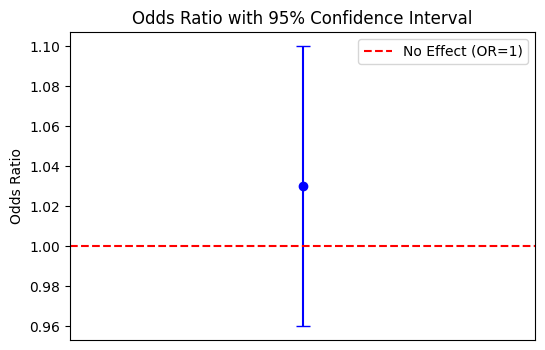

In [36]:
odds_ratio = 1.03
conf_int = [0.96, 1.10]

plt.figure(figsize=(6, 4))
plt.errorbar(1, odds_ratio, yerr=[[odds_ratio - conf_int[0]], [conf_int[1] - odds_ratio]], fmt='o', capsize=5, color='blue')
plt.axhline(1, linestyle='--', color='red', label='No Effect (OR=1)')
plt.title('Odds Ratio with 95% Confidence Interval')
plt.ylabel('Odds Ratio')
plt.xlim(0.5, 1.5)
plt.xticks([])
plt.legend()
plt.show()


## Converted and Test group

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


In [41]:
# Create a contingency table
contingency_table_CT = pd.crosstab(df['converted'], df['test group'])

print("Contingency Table with Frequencies:")
display(contingency_table_CT)
print("#"*60)

# Calculate row percentages
row_percentages_CT = contingency_table_CT.div(contingency_table_CT.sum(axis=1), axis=0) * 100

print("\nRow Percentages:")
display(row_percentages_CT)
print("#"*60)

# Perform chi-square test
chi2, p, dof, expected_CT = chi2_contingency(contingency_table_CT)

print(f"\nChi-squared value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("#"*60)

# Calculate the percentage of cells with expected counts less than 5
percentage_low_expected_CT = (expected < 5).sum().sum() / (expected.shape[0] * expected.shape[1]) * 100

print(f"Percentage of cells with expected counts less than 5: {percentage_low_expected_CT:.2f}%")
print("#"*60)

# Calculate residuals (observed minus expected values)
residuals_CT = contingency_table_CT - expected_CT

print("\nResiduals (Observed - Expected):")
display(residuals_CT)
print("#"*60)

# Calculate odds ratio
OR_CIs(contingency_table_CT)

Contingency Table with Frequencies:


test group,ad,psa
converted,,
False,550154,23104
True,14423,420


############################################################

Row Percentages:


test group,ad,psa
converted,,
False,95.969703,4.030297
True,97.170383,2.829617


############################################################

Chi-squared value: 54.005823883685245
P-value: 1.9989623063390075e-13
Degrees of freedom: 1
############################################################
Percentage of cells with expected counts less than 5: 0.00%
############################################################

Residuals (Observed - Expected):


test group,ad,psa
converted,,
False,-173.71899,173.71899
True,173.71899,-173.71899


############################################################
Odds Ratio: 0.69
95% Confidence Interval: 0.63, 0.76


### * Percentage of Cells with Expected Counts Less Than 5:

0.00% of cells have expected counts less than 5, indicating that the chi-squared test assumptions are met and the results are valid.

### * Residuals (Observed - Expected)

The positive residual for the "psa" group (173.72) indicates that more people converted than expected, while the negative residual for the "ad" group (-173.72) suggests fewer conversions than expected. This reinforces the observation that the ads did not perform as well as anticipated compared to the public service announcements.

### * Odds Ratio:

The odds ratio of 0.69 suggests that the odds of conversion in the "ad" group are lower compared to the "psa" group. Specifically, for every unit increase in the "psa" group, the odds of conversion decrease by about 31% (1 - 0.69 = 0.31). The confidence interval not crossing 1 reinforces the significance of this finding.

### * conclusion:

the analysis indicates a significant difference in conversion rates between the ad and psa groups, with the ads showing a lower conversion rate. This suggests that the advertisement campaign might not have been effective, and companies may want to reconsider their strategies or conduct further testing to optimize their approach.


**Let's visulize the result:**

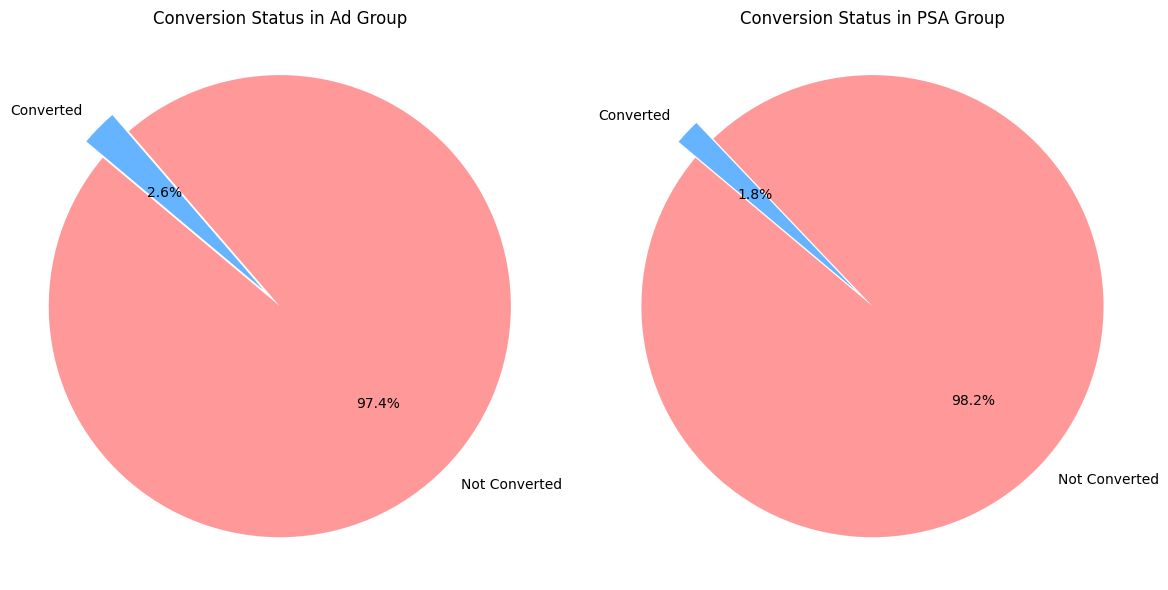

In [42]:
import matplotlib.pyplot as plt

# Data for 'ad' and 'psa' groups
labels = ['Not Converted', 'Converted']
sizes_ad = [550154, 14423]  # False, True counts for 'ad'
sizes_psa = [23104, 420]    # False, True counts for 'psa']
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  # explode 1st slice (Not Converted)

# Create subplots for side-by-side pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for 'ad' group
axes[0].pie(sizes_ad, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Conversion Status in Ad Group')
axes[0].axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.

# Pie chart for 'psa' group
axes[1].pie(sizes_psa, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Conversion Status in PSA Group')
axes[1].axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.

# Display both pie charts
plt.tight_layout()
plt.show()


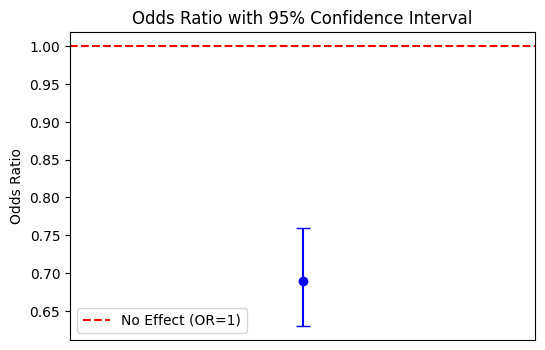

In [43]:
odds_ratio = 0.69  # This is a placeholder value
conf_int = [0.63, 0.76]  # Confidence interval for the odds ratio

plt.figure(figsize=(6, 4))
plt.errorbar(1, odds_ratio, yerr=[[odds_ratio - conf_int[0]], [conf_int[1] - odds_ratio]], fmt='o', capsize=5, color='blue')
plt.axhline(1, linestyle='--', color='red', label='No Effect (OR=1)')
plt.title('Odds Ratio with 95% Confidence Interval')
plt.ylabel('Odds Ratio')
plt.xlim(0.5, 1.5)
plt.xticks([])
plt.legend()
plt.show()

# Independent Samples t-Test

## Converted and Total ads

**Assumption of Homogeneity of Variance in Independent Samples t-Test**

In [44]:

from scipy.stats import levene


# Separate the 'time' data into two groups based on the 'converted' column
groupN = df[df['converted'] == False]['total ads']
groupY = df[df['converted'] == True]['total ads']

# Perform Levene's test for homogeneity of variances
statistic, p_value = levene(groupN, groupY)

# Print the results
print("Levene's test statistic:", statistic)
print("p-value:", p_value)

# Determine significance
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Variances are not homogeneous between groups.")
else:
    print("Fail to reject the null hypothesis: Variances are homogeneous between groups.")

Levene's test statistic: 9121.196956737573
p-value: 0.0
Reject the null hypothesis: Variances are not homogeneous between groups.


**T-Test with Non-Met Equal Variance Assumption**

In [45]:
from scipy.stats import ttest_ind


# Separate the data into two groups based on the 'converted' column
groupN = df[df['converted'] == False]['total ads']
groupY = df[df['converted'] == True]['total ads']
# Perform two-sample t-test
t_statistic, p_value = ttest_ind(groupN, groupY, equal_var=False)

# Print the results
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Determine significance
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means.")

t-statistic: -84.17740664633055
p-value: 0.0
Reject the null hypothesis: There is a significant difference between the means.


### Interpretation of the Statistical Tests:

#### 1. **Levene's Test for Homogeneity of Variances:**
   - **Levene's test statistic:** 9121.20
   - **p-value:** 0.0
   - The **p-value** is less than the significance level \(\alpha = 0.05\), so we **reject the null hypothesis**, which states that the variances are equal between the two groups (converted and non-converted).
   - This means that the variances of **total ads** between users who converted and those who did not are significantly different, implying unequal spread of the data in each group.

#### 2. **Independent t-test (with unequal variances):**
   - **t-statistic:** -84.18
   - **p-value:** 0.0
   - The **p-value** is also less than \(\alpha = 0.05\), so we **reject the null hypothesis**. This means there is a statistically significant difference in the means of **total ads** seen between the converted and non-converted groups.
   - Since the **t-statistic** is negative, it indicates that the mean number of ads seen by the non-converted group is higher than the mean for the converted group.

#### **Conclusion:**
   - The variances between the two groups are not homogeneous, as indicated by Levene's test.
   - There is a significant difference in the means of **total ads** seen between the groups. On average, users who did not convert saw more ads than those who converted.
   
This suggests that exposing users to more ads does not necessarily increase the likelihood of conversion, and there might be an optimal threshold of ad exposure beyond which users do not engage further.

In [46]:
# Descriptive statistics for the 'total ads' seen by converted and non-converted groups
print(groupN.describe())  # Non-converted group
print(groupY.describe())  # Converted group


count    573258.000000
mean         23.291495
std          40.863176
min           1.000000
25%           4.000000
50%          13.000000
75%          26.000000
max        2065.000000
Name: total ads, dtype: float64
count    14843.000000
mean        83.887759
std         87.455498
min          1.000000
25%         35.000000
50%         64.000000
75%        103.000000
max       1778.000000
Name: total ads, dtype: float64




### Key Insights:
- **Converted users saw more ads on average (mean = 83.89)** compared to **non-converted users (mean = 23.29)**.
- The **converted group** has a much higher spread of total ads seen, with both the standard deviation (87.46) and the interquartile range (from 35 to 103 ads) being larger than that of the non-converted group.
- **Non-converted users** tend to have lower total ad exposure, as seen by the **median of 13 ads** compared to **64 ads** in the converted group.

These statistics highlight a clear difference between the groups, suggesting that **converted users are exposed to significantly more ads** on average. This ties into the earlier result showing a significant difference in ad exposure between the two groups.

In [47]:
import numpy as np

# Mean and standard deviation for both groups
meanN, meanY = np.mean(groupN), np.mean(groupY)
stdN, stdY = np.std(groupN, ddof=1), np.std(groupY, ddof=1)

# Compute pooled standard deviation
pooled_std = np.sqrt(((len(groupN) - 1) * stdN**2 + (len(groupY) - 1) * stdY**2) / (len(groupN) + len(groupY) - 2))

# Calculate Cohen's d
cohen_d = (meanN - meanY) / pooled_std
print(f"Cohen's d: {cohen_d}")


Cohen's d: -1.4201314076149827


### Interpretation of Cohen's d:

- **Cohen's d:** -1.42

Cohen's d measures the **effect size**, or the magnitude of the difference between the two groups (converted and non-converted) in terms of **total ads** seen.

#### Interpretation of the Value:
- A **Cohen's d** of **-1.42** is considered a **large effect size**. This means that the difference in the number of ads seen between the converted and non-converted groups is **substantial**.
- The negative sign indicates that the **non-converted** group saw **more ads** than the **converted** group, reinforcing the finding that users who do not convert tend to see significantly more ads.

#### General Guidelines for Cohen's d:
- **0.2** = small effect
- **0.5** = medium effect
- **0.8** or higher = large effect

With a **Cohen's d** of -1.42, this is a **strong difference**, suggesting that the exposure to ads is meaningfully different between the two groups, with **non-converted** users experiencing significantly more ad exposure.

# A/B Test the equality of proportions hypothesis

In [48]:
cross_tab = pd.crosstab(df['test group'], df['converted'], normalize='index')
cross_tab

converted,False,True
test group,,
ad,0.974453,0.025547
psa,0.982146,0.017854


## **Define the null and alternative hypothsis**

* Null Hypothesis (H₀): there is no difference in the conversion rates between the test group
* Alternative Hypothesis : there is a difference in the conversion rates between the test group and the control group

## **Set the probability of type I and type II errors**

* we set : α=0.05 and β=0.2.

## **Calculate the sample size**

Based on the provided conversion data, we have the conversion rates for two groups in an A/B test: one group that saw the advertisement ("ad") and another that saw a public service announcement ("psa"). The conversion rates are calculated as follows:

**Ad Group:**

* Conversion Rate: 2.55% (0.025547)

**PSA Group:**

* Conversion Rate: 1.79% (0.017854)
To determine the sample size needed for such an A/B test, you can use these conversion rates as your baseline rates (p1 and p2). Here's how you can proceed:
Steps to Determine Sample Size

**Define Parameters:**

* Baseline Conversion Rate (p1): Use the conversion rate of the PSA group, which is 1.79%.
* Expected Conversion Rate (p2): Use the conversion rate of the Ad group, which is 2.55%.
* Significance Level (α): Typically set at 0.05.
* Power (1-β): Typically set at 0.8 (80%).

In [49]:
from statsmodels.stats.power import NormalIndPower

# Parameters
alpha = 0.05  # Significance level
power = 0.8   # Power
p1 = 0.017854  # Conversion rate for control group (psa)
p2 = 0.025547  # Conversion rate for test group (ad)

# Calculate the average conversion rate
p = (p1 + p2) / 2

# Calculate the effect size
effect_size = (p2 - p1) / ((p * (1 - p)) ** 0.5)

# Calculate the sample size per group
power_analysis = NormalIndPower()
sample_size = power_analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, ratio=1)

print(f"Required sample size per group: {int(sample_size)}")


Required sample size per group: 5631


## Choose samples

In [50]:
def choose_random_sample(data,random_state=42):
    return data.sample(n=int(sample_size), random_state=random_state)

# Apply the function to each group using groupby
df_smpl = df.groupby('test group', group_keys=False).apply(choose_random_sample)

# Displaying the random sample
print(df_smpl)

        Unnamed: 0  user id test group  converted  total ads most ads day  \
529666      529666  1300427         ad      False         21       Friday   
385537      385537  1197483         ad      False          2     Thursday   
120467      120467  1234257         ad      False         20       Sunday   
186608      186608  1384841         ad       True         47       Friday   
141292      141292  1646962         ad      False         13      Tuesday   
...            ...      ...        ...        ...        ...          ...   
158646      158646   909937        psa      False          7     Thursday   
521629      521629   903824        psa      False          6     Thursday   
376798      376798   920768        psa      False          7    Wednesday   
282973      282973   908849        psa      False         12       Monday   
547431      547431   902688        psa      False         24       Monday   

        most ads hour  
529666             20  
385537             20  
120

## visulize samples

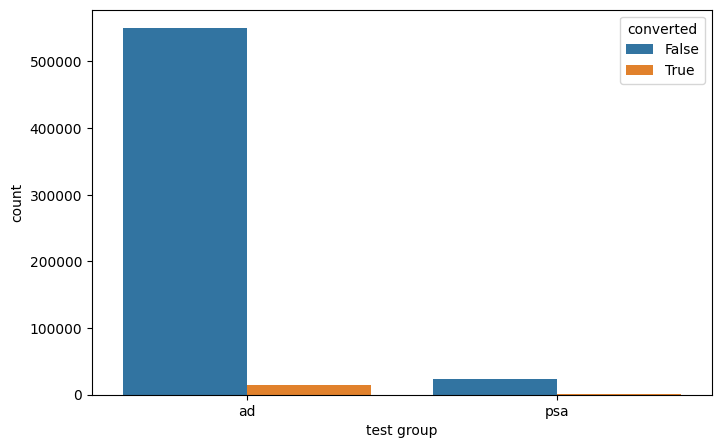

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 5))

sns.countplot(df, x='test group', hue='converted', ax=ax)

plt.show()

## **Test the equality of proportions hypothesis**

In [52]:
import pandas as pd
import statsmodels.api as sm

# Create the contingency table
contingency_table_Z = pd.crosstab(df_smpl['test group'], df_smpl['converted'])


print("Contingency Table with Frequencies:")
print(contingency_table_Z)
print("#"*60)

# Calculate row percentages
row_percentages = contingency_table_Z.div(contingency_table_Z.sum(axis=1), axis=0) * 100

print("\nRow Percentages:")
print(row_percentages)
print("#"*60)

# Count the number of successes and trials in each group
success_ad = contingency_table_Z.loc['ad', True]
trials_ad = contingency_table_Z.loc['ad', False] + contingency_table_Z.loc['ad', True]

success_psa = contingency_table_Z.loc['psa', True]
trials_psa = contingency_table_Z.loc['psa', False] + contingency_table_Z.loc['psa', True]

# Perform the z-test for proportions
z_stat, p_value = sm.stats.proportions_ztest(
    [success_ad, success_psa],
    [trials_ad, trials_psa],
    alternative='larger'
)

# Print the results
print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in proportions.")
else:
    print("Fail to reject the null hypothesis. Proportions are not significantly different.")

Contingency Table with Frequencies:
converted   False  True 
test group              
ad           5481    150
psa          5524    107
############################################################

Row Percentages:
converted       False     True 
test group                     
ad          97.336175  2.663825
psa         98.099805  1.900195
############################################################
Z-statistic: 2.7134050689178086
P-value: 0.003329782308620703
Reject the null hypothesis. There is a significant difference in proportions.


* A p-value of 0.0033 is less than the significance level (typically 0.05), meaning we reject the null hypothesis.

* This indicates that there is a statistically significant difference in the proportions of conversions between the ad group and the PSA group. The difference in the proportions (2.66% vs. 1.90%) is not due to random chance.

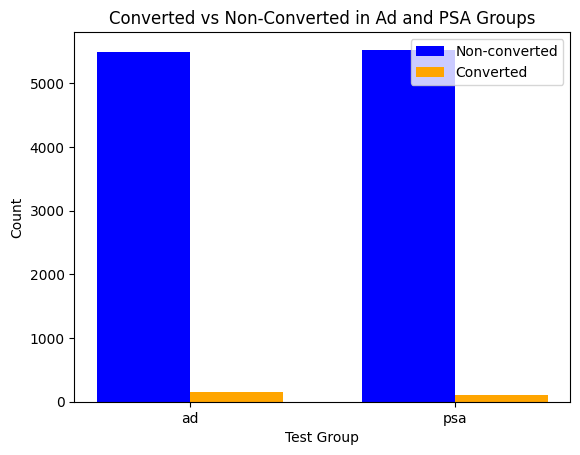

In [53]:
import matplotlib.pyplot as plt

# Data from the contingency table
groups = ['ad', 'psa']
false_values = [5481, 5524]
true_values = [150, 107]

# Plot a grouped bar chart
bar_width = 0.35
index = range(len(groups))

plt.bar(index, false_values, bar_width, label='Non-converted', color='blue')
plt.bar([i + bar_width for i in index], true_values, bar_width, label='Converted', color='orange')

plt.xlabel('Test Group')
plt.ylabel('Count')
plt.title('Converted vs Non-Converted in Ad and PSA Groups')
plt.xticks([i + bar_width / 2 for i in index], groups)
plt.legend()
plt.show()


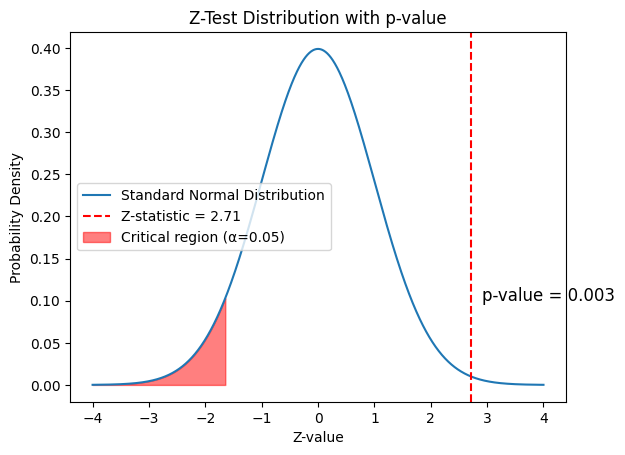

In [54]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Z-statistic and p-value (from your z-test result)
z_stat = 2.7134050689178086
p_value = 0.003329782308620703  # From your z-test result
alpha = 0.05

# Generate data for normal distribution
z_values = np.linspace(-4, 4, 1000)
y_values = stats.norm.pdf(z_values)

# Plot the z-distribution
plt.plot(z_values, y_values, label='Standard Normal Distribution')
plt.axvline(z_stat, color='red', linestyle='--', label=f'Z-statistic = {z_stat:.2f}')
plt.fill_between(z_values, y_values, where=(z_values < stats.norm.ppf(alpha)), color='red', alpha=0.5, label=f'Critical region (α={alpha})')

# Add the p-value as text on the plot
plt.text(z_stat + 0.2, 0.1, f'p-value = {p_value:.3f}', color='black', fontsize=12)

plt.title('Z-Test Distribution with p-value')
plt.xlabel('Z-value')
plt.ylabel('Probability Density')
plt.legend()
plt.show()


## **Calculate the confidence interval for odds ratio**

In [55]:
import numpy as np
import pandas as pd
from scipy.stats import norm

def OR_CIs(contingency_table):

    # Calculate odds ratio
    odds_ratio = (contingency_table.iloc[0, 0] / contingency_table.iloc[0, 1]) / (contingency_table.iloc[1, 0] / contingency_table.iloc[1, 1])

    # Calculate standard error of log(odds ratio)
    log_odds_std_error = np.sqrt(contingency_table.applymap(lambda x: 1/x).sum().sum())

    # Set confidence level
    confidence_level = 0.95

    # Calculate z-score for the confidence interval
    z_score = norm.ppf(1-(1 - confidence_level) / 2)

    # Calculate confidence intervals
    ci_low = np.exp(np.log(odds_ratio) - z_score * log_odds_std_error)
    ci_high = np.exp(np.log(odds_ratio) + z_score * log_odds_std_error)

    # Print the results
    print(f"Odds Ratio: {odds_ratio:.2f}")
    print(f"95% Confidence Interval: {ci_low:.2f}, {ci_high:.2f}")

    return
# Calculate the confidence interval for odds ratio
OR_CIs(contingency_table_Z)

Odds Ratio: 0.71
95% Confidence Interval: 0.55, 0.91


* The odds ratio of 0.71 means that the odds of converting in the ad group are 29% lower (1 - 0.71 = 0.29) than in the PSA group.

* The confidence interval (0.55 to 0.91) does not include 1, which indicates that the result is statistically significant. In other words, we are 95% confident that the true odds ratio lies within this range, confirming that there is a difference in conversion odds between the groups.

In [ ]:
odds_ratio = 0.71  # This is a placeholder value
conf_int = [0.55, 0.91]  # Confidence interval for the odds ratio

plt.figure(figsize=(6, 4))
plt.errorbar(1, odds_ratio, yerr=[[odds_ratio - conf_int[0]], [conf_int[1] - odds_ratio]], fmt='o', capsize=5, color='blue')
plt.axhline(1, linestyle='--', color='red', label='No Effect (OR=1)')
plt.title('Odds Ratio with 95% Confidence Interval')
plt.ylabel('Odds Ratio')
plt.xlim(0.5, 1.5)
plt.xticks([])
plt.legend()
plt.show()

**Overall Interpretation:**

* **There is a statistically significant difference** in conversion rates between the ad and PSA groups.

* Although the conversion rate in the ad group (2.66%) is slightly higher than in the PSA group (1.90%), the odds ratio of 0.71 suggests that users exposed to the ad have **lower odds of converting** than those exposed to the PSA.

* While the ad group had a higher conversion percentage, the odds ratio indicates that **users in the PSA group had a better relative chance of converting** compared to the ad group, when accounting for odds rather than raw proportions.